In [ ]:
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import random
import pickle
import glob

from trainer import Trainer, OptimizerName
from model import LeNet5, LeNet5_deform
from augment_generator import AugmentGenerator

import warnings

---
## Step0: Load the data

#### Load the original data

In [2]:
training_file = './traffic-signs-data/train.p'
validation_file = './traffic-signs-data/valid.p'
test_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(test_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

#### Augment the data

In [ ]:
augen = AugmentGenerator(20, 10, 5)
X_gen_train, y_gen_train = augen.generate(X_train, y_train, 10)

In [ ]:
augmented = {'features': X_gen_train, 'labels': y_gen_train}

with open('./traffic-signs-data/augmented.p', mode='wb') as f:
    pickle.dump(augmented, f)

In [ ]:
augment_file = './traffic-signs-data/augmented.p'

with open(augment_file, mode='rb') as f:
    augment = pickle.load(f)
    
X_aug, y_aug = augment['features'], augment['labels']

In [ ]:
X_train = np.vstack((X_train, X_aug))
y_train = np.hstack((y_train, y_aug))
print(len(X_train), len(y_train))

In [ ]:
X_train = np.array([cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)[:,:,np.newaxis] for x in X_train])
X_valid = np.array([cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)[:,:,np.newaxis] for x in X_valid])
X_test = np.array([cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)[:,:,np.newaxis] for x in X_test])

---
## Step1: Dataset Summary & Exploration
The pickled data is a dictionary with 4 key/value pairs:
 - 'features' is a 4D array containing raw pixel data of the traffic sign images.
 - 'labels' is a 1D array containing the label/class id of the traffic sign. The file signnames.csv contains id -> name mappings for each id.
 - 'sizes' is a list containing tuples, (width,height) representing the original width and height the image.
 - 'coords' is a list containing tuples, (x1,y1,x2,y2) representing coordinates of a bounding box around the sign in the image.**These coordinates assume the original image. The pickled data contains resized versions(32x32) of these images.**

In [3]:
n_train = X_train.shape[0]
n_valid = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = X_train[0].shape
n_classes = pd.Series(y_train).nunique()

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [ ]:
n_aug = X_aug.shape[0]
print("Number of augmentated examples =", n_aug)

#### Observe the test data randomly
You can see the test data by pressing keys [ctl]+[enter].

In [ ]:
rand_idx = random.randint(0, X_train.shape[0])
plt.imshow(X_train[rand_idx])
plt.title(rand_idx)

In [ ]:
path = 'signnames.csv'
sign_names = pd.read_csv(path)

In [ ]:
plt.figure(figsize=(20, 8))
plt.hist(y_train, bins=n_classes, rwidth=0.8, label='train')
plt.hist(y_test, bins=n_classes, rwidth=0.8, label='test')
plt.hist(y_valid, bins=n_classes, rwidth=0.8, label='validation')
plt.title('Data distributions')
plt.xticks(sign_names['ClassId'], sign_names['SignName'], rotation=90)
plt.legend()
plt.show()

---
## Step2: Design and Test a Model Architecture

##### Pre-process the Data Set

In [4]:
# Normalize pixel values to 0-1
X_train = X_train/255.
X_valid = X_valid/255.
X_test = X_test/255.

In [5]:
# To ignore the warnings caused by tensorflow module
warnings.filterwarnings('ignore')

trainer = Trainer(OptimizerName.ADAM, 0.001)
model = LeNet5_deform(image_shape[2], n_classes, trainer.optimizer)
saver = tf.train.Saver()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [6]:
def evaluation(model, X_data, y_data):
    total_acc = 0
    for offset in range(0, len(X_data), BATCH_SIZE):
        end = offset + BATCH_SIZE
        X_batch = X_data[offset:end]
        y_batch = y_data[offset:end]
        acc = sess.run(
            model.evaluate,
            feed_dict={model.x: X_batch, model.y: y_batch})
        total_acc += acc * len(X_batch)
    return total_acc / len(X_data)

In [7]:
save_path = './lenet'
save_path_color = './cp_color/lenet'

In [ ]:
# To ignore the warnings caused by tensorflow module
warnings.filterwarnings('ignore')

EPOCH = 100
BATCH_SIZE = 128
best_acc = 0.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for e in range(EPOCH):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, n_train, BATCH_SIZE):
            end = offset + BATCH_SIZE
            X_batch = X_train[offset: end]
            y_batch = y_train[offset: end]
            sess.run(
                model.train,
                feed_dict={model.x: X_batch, model.y: y_batch})
        valid_accuracy = evaluation(model, X_valid, y_valid)  
        if valid_accuracy > best_acc:
            best_acc = valid_accuracy
            saver.save(sess, save_path_color)
            print("Save checkpoint!!")
        print("Epoch{} => Validation Accuracy: {:.3f}".format(e+1, valid_accuracy))

In [8]:
# To ignore the warnings caused by tensorflow module
warnings.filterwarnings('ignore')

BATCH_SIZE = 128
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('./cp_color/lenet.meta')
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluation(model, X_test, y_test)    
    print("Test Accuracy: {:.3f}".format(test_accuracy))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from .\lenet
Test Accuracy: 0.943


## Step3: Test a Model on New Images

#### Load and Output the Images

In [9]:
def read_images_size_as(paths, size=(32,32)):
    resized = []
    images = [cv2.imread(path) for path in paths]
    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, dsize=size)
        resized.append(img)
    return np.array(resized)

In [10]:
img_paths = glob.glob('./test_images/*.jpg')
images = read_images_size_as(img_paths, (32,32))
labels = np.array([38, 5, 11, 22, 23, 9, 2, 22, 20])

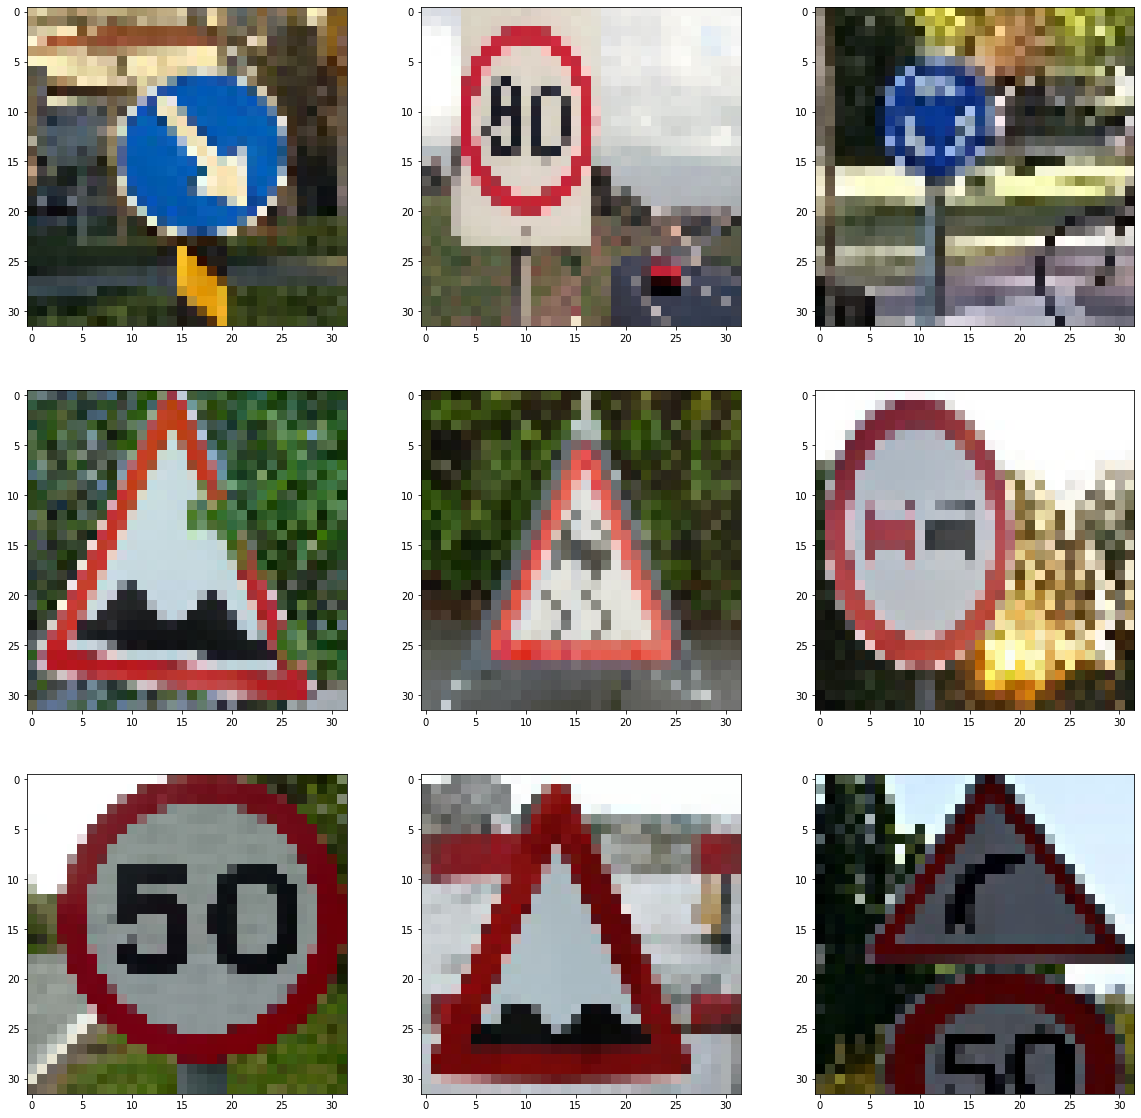

In [11]:
plt.figure(9, figsize=(20,20))
for i, img in enumerate(images):
    plt.subplot(3,3,i+1)
    plt.imshow(img, interpolation="nearest", cmap='gray')

#### Predict the Sign Type for Each Image and Output the Performance

In [12]:
images = images/255.

In [13]:
# To ignore the warnings caused by tensorflow module
warnings.filterwarnings('ignore')

BATCH_SIZE = 128

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('./cp_color/lenet.meta')
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluation(model, images, labels)    
    print("Test Accuracy: {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\lenet
Test Accuracy: 0.333


#### Output Top5 softmax probabilities

INFO:tensorflow:Restoring parameters from .\lenet


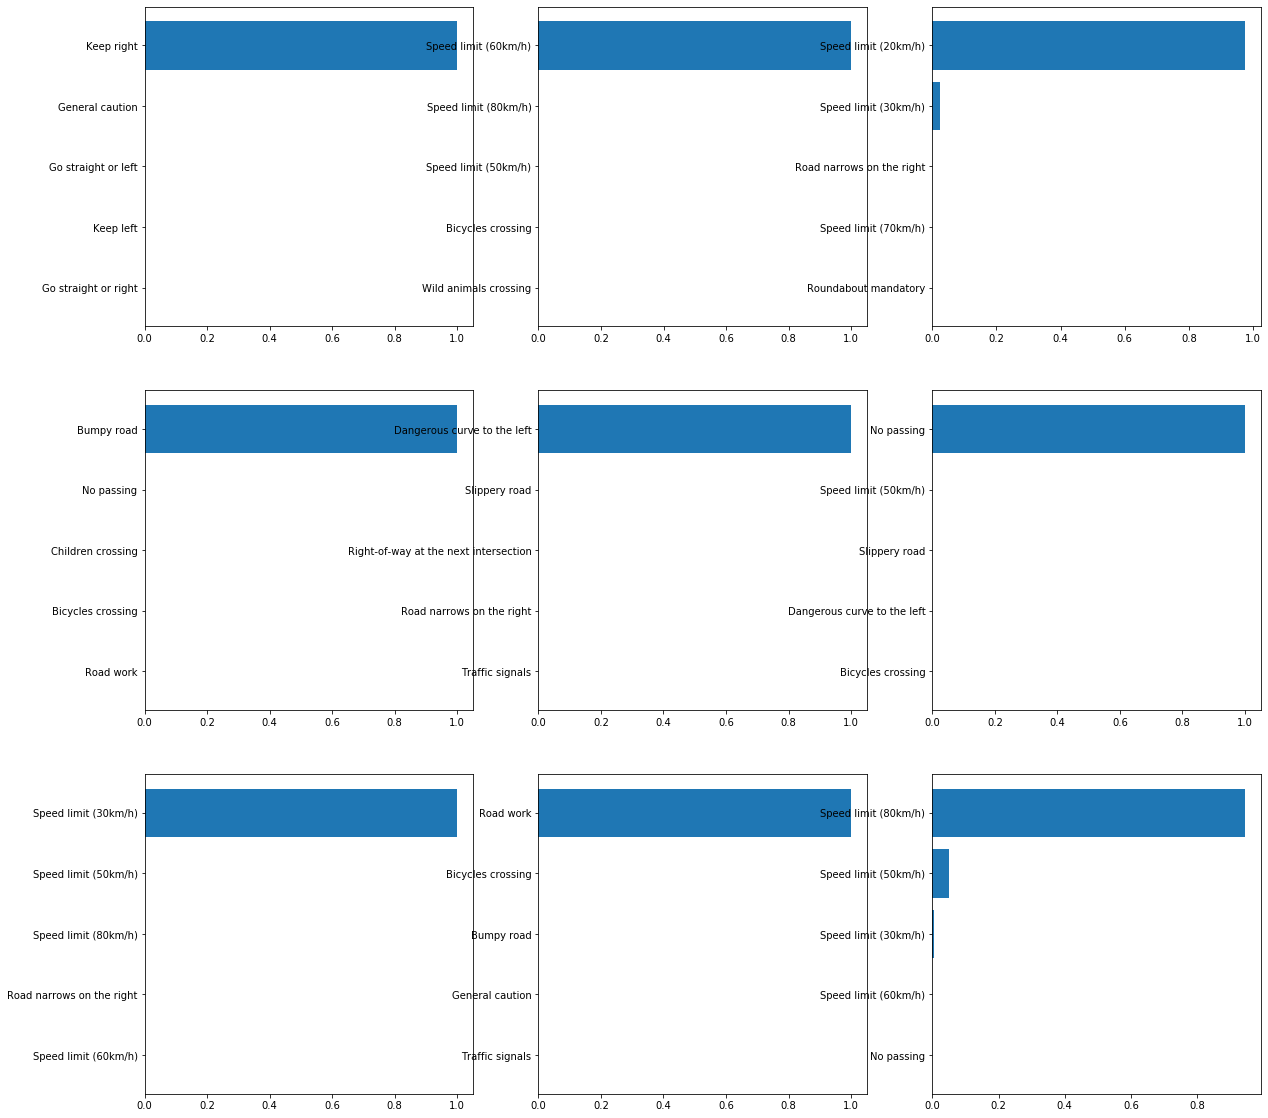

In [14]:
logit = tf.nn.softmax(model.logits)
top_5 = tf.nn.top_k(logit, k=5)

path = 'signnames.csv'
sign_names = pd.read_csv(path)

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('./cp_color/lenet.meta')
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    probs, indices = sess.run(top_5, feed_dict={model.x: images})
    
    fig = plt.figure(figsize=(20,20))
    for i in range(len(probs)):
        labels = [sign_names.loc[idx, "SignName"] for idx in indices[i][::-1]]
        ax = fig.add_subplot(3,3,i+1)
        ax.barh(np.arange(5), probs[i][::-1])
        ax.set_yticks(np.arange(5))
        ax.set_yticklabels(labels)
    plt.show()

## Visualize the Neural Network's State

In [ ]:
def output_feature_map(image_input, tf_activation, activation_min=-1, activation_max=-1, plt_num=1):
    activation = tf_activation.eval(session=sess, feed_dict={model.x: image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))

    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1)
        plt.title('FeatureMap ' + str(featuremap))
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

In [ ]:
rand_idx = random.randint(0, X_train.shape[0])
plt.imshow(X_train[rand_idx])

In [ ]:
sess = tf.InteractiveSession()
saver.restore(sess, tf.train.latest_checkpoint('.'))

##### See the feature map of training data

In [ ]:
output_feature_map(X_train[rand_idx:rand_idx+1], model.conv1a)

In [ ]:
output_feature_map(X_train[rand_idx:rand_idx+1], model.conv1b)

In [ ]:
output_feature_map(X_train[rand_idx:rand_idx+1], model.conv2a)

In [ ]:
output_feature_map(X_train[rand_idx:rand_idx+1], model.conv2b)

##### See the feature map of image on web

In [ ]:
output_feature_map(images[1:2], model.conv1a)

In [ ]:
output_feature_map(images[1:2], model.conv1b)

In [ ]:
output_feature_map(images[1:2], model.conv2a)

In [ ]:
output_feature_map(images[1:2], model.conv2b)

In [ ]:
sess.close()